# Test on real data

In [1]:
# Load libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
# Import written libraries
import src.utils as ut
import src.fuzz as fz
import src.classif as cl

## Iris dataset

In [3]:
iris = load_iris(as_frame=True)  # returns a dict-like object
df = iris.frame  # get as pandas DataFrame

In [4]:
X = df.drop(columns='target')  # features
y = df['target']  # target

# Turn into array
X = np.array(X)
y = np.array(y)

In [5]:
# Hyperparameters
dim = X.shape[1]  # number of features
nb_classes = len(np.unique(y))  # number of classes

# Normalize data
data_norm = fz.batch_norm(X)
data_labels = ut.convert_to_float_lst(y)
print(f"Normalized data: {data_norm.shape[0]} samples in {data_norm.shape[1]}D space.")

Normalized data: 150 samples in 4D space.


[0, 0.0863408753977487, 0.1523605000177355, 0.2557283775335084, 0.26944397476748394, 0.3487005736712524, 0.35606831532959926, 0.37212611207681867, 0.4628314623248403, 0.6096404107296276, 0.7135735325649857, 0.7154915019374875, 0.7868913341378256, 0.8466391438771368, 0.866999163329851, 0.9512881178720017]
Leave one out avec k = 1
SimLevel1: 0.3333333333333333
SimLevel2: 0.43333333333333335
SimLevel3: 0.3333333333333333

Result in 3.2117 seconds.
[0, 0.01694351161867469, 0.11690046380172625, 0.1218772453476259, 0.138094872895008, 0.17905258626837584, 0.24392676007217162, 0.2633696751954342, 0.32204973911998835, 0.34905623485693005, 0.35969715417053005, 0.6597776138134126, 0.6660456025220535, 0.7109782254505151, 0.7237118544936806, 0.8330605026794279]
Leave one out avec k = 2
SimLevel1: 0.3333333333333333
SimLevel2: 0.43333333333333335
SimLevel3: 0.3333333333333333

Result in 3.2206 seconds.
[0, 0.013875139241255607, 0.0373355546398727, 0.053807346862263516, 0.2720865717387536, 0.29424077

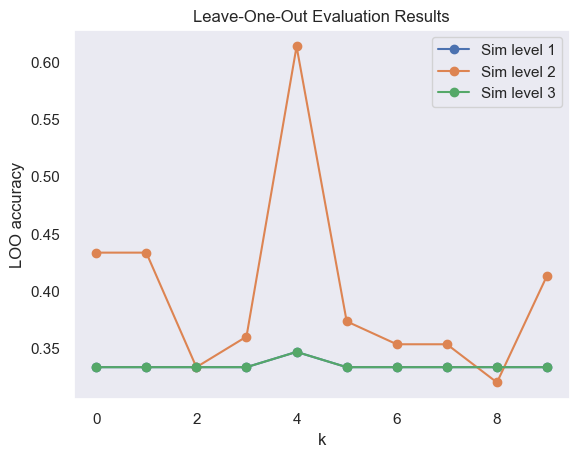

In [6]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = fz.generate_capacity(ut.enumerate_permute_batch(data_norm[0]),2**len(data_norm[0])-1)
    print(mu)

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel1), 
            DS = (data_norm, data_labels)
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel2), 
            DS = (data_norm, data_labels)
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel3), 
            DS = (data_norm, data_labels)
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()
plt.savefig("archive/iris_accuracy.png")

In [7]:
penguins = load_penguins()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [8]:
le = LabelEncoder()
le.fit(penguins['island'])
penguins['island'] = le.transform(penguins['island'])

le.fit(penguins['sex'])
penguins['sex'] = le.transform(penguins['sex'])

In [9]:
le.fit(penguins['species'])
penguins['species'] = le.transform(penguins['species'])

In [10]:
penguins = penguins.dropna()  # remove rows with missing values
X = penguins.drop(columns='species')  # features
y = penguins['species']  # target

# Turn into array
X = np.array(X)
y = np.array(y)

In [11]:
# Hyperparameters
dim = X.shape[1]  # number of features
nb_classes = len(np.unique(y))  # number of classes

# Normalize data
data_norm = fz.batch_norm(X)
data_labels = ut.convert_to_float_lst(y)
print(f"Normalized data: {data_norm.shape[0]} samples in {data_norm.shape[1]}D space.")

Normalized data: 342 samples in 7D space.


[0, 0.001747662022784091, 0.013613555708395175, 0.017975052459385688, 0.028612781941173115, 0.029060901731983724, 0.03525324188678247, 0.0476753698507737, 0.060862609799763434, 0.0640124453388321, 0.07798569952957202, 0.11154105924978741, 0.11314319166214559, 0.11790699144630579, 0.1588854502298941, 0.16502656459535192, 0.17362056925859004, 0.17398631015930588, 0.17984725570241367, 0.17984730632739232, 0.1830660269306209, 0.19783603661940552, 0.20402678558529264, 0.21753084430579794, 0.21842002330474053, 0.22486796460747516, 0.23010549427467797, 0.23251595327825703, 0.23871858188623296, 0.25056207923115414, 0.2511772748308334, 0.25442644152166194, 0.27331138108606434, 0.30041745520902796, 0.30450661631507703, 0.30531776599538185, 0.3262275613188139, 0.33241473404324307, 0.3388131578452416, 0.34819817517487994, 0.3485282411982933, 0.35546762249631636, 0.37731749985522756, 0.37814790921928665, 0.38244800945392343, 0.38765652424710617, 0.416523715679179, 0.4244196454721506, 0.424990316479

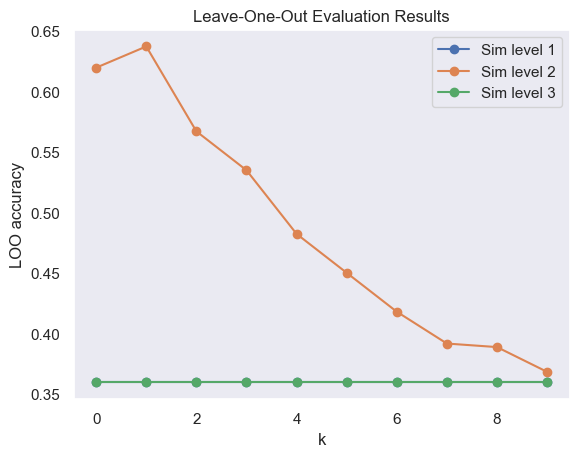

In [12]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = fz.generate_capacity(ut.enumerate_permute_batch(data_norm[0]),2**len(data_norm[0])-1)
    print(mu)

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel1), 
            DS = (data_norm, data_labels)
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel2), 
            DS = (data_norm, data_labels)
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel3), 
            DS = (data_norm, data_labels)
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()
plt.savefig("archive/penguins_accuracy.png")